# Explore the C. elegans data

Visualize embeddings and cell nubmers

Changelog
- XXX. 

## Preliminaries

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import anndata as ad
import moscot as mc
import moslin_utils as mu
from moslin_utils.constants import FIG_DIR, DATA_DIR, TIME_KEY, TIMEPOINTS
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import numpy as np

Print the moscot version

In [3]:
mc.__version__

'0.3.4'

### Dependencies

Depends on []

### Define utility functions

### Set up paths

Define the paths for data and figures

In [4]:
FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

In [5]:
sc.settings.set_figure_params("scanpy", frameon=False)

Set up the paths to save figures.

In [6]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

### Set global parameters

In [7]:
mu.settings.save_figures = False

RANDOM_STATE = 0

### Import data and metadata

In [8]:
adata = ad.read_h5ad(DATA_DIR / "ML_2024-06-09_c_elegans_prep.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'

## Visualize the data

Subset to the relevant timepoints. 

In [9]:
adata = adata[adata.obs[TIME_KEY].isin(TIMEPOINTS)].copy()
adata.uns[f"{TIME_KEY}_colors"] = [
    mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(TIMEPOINTS)))
]

adata

AnnData object with n_obs × n_vars = 45732 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'

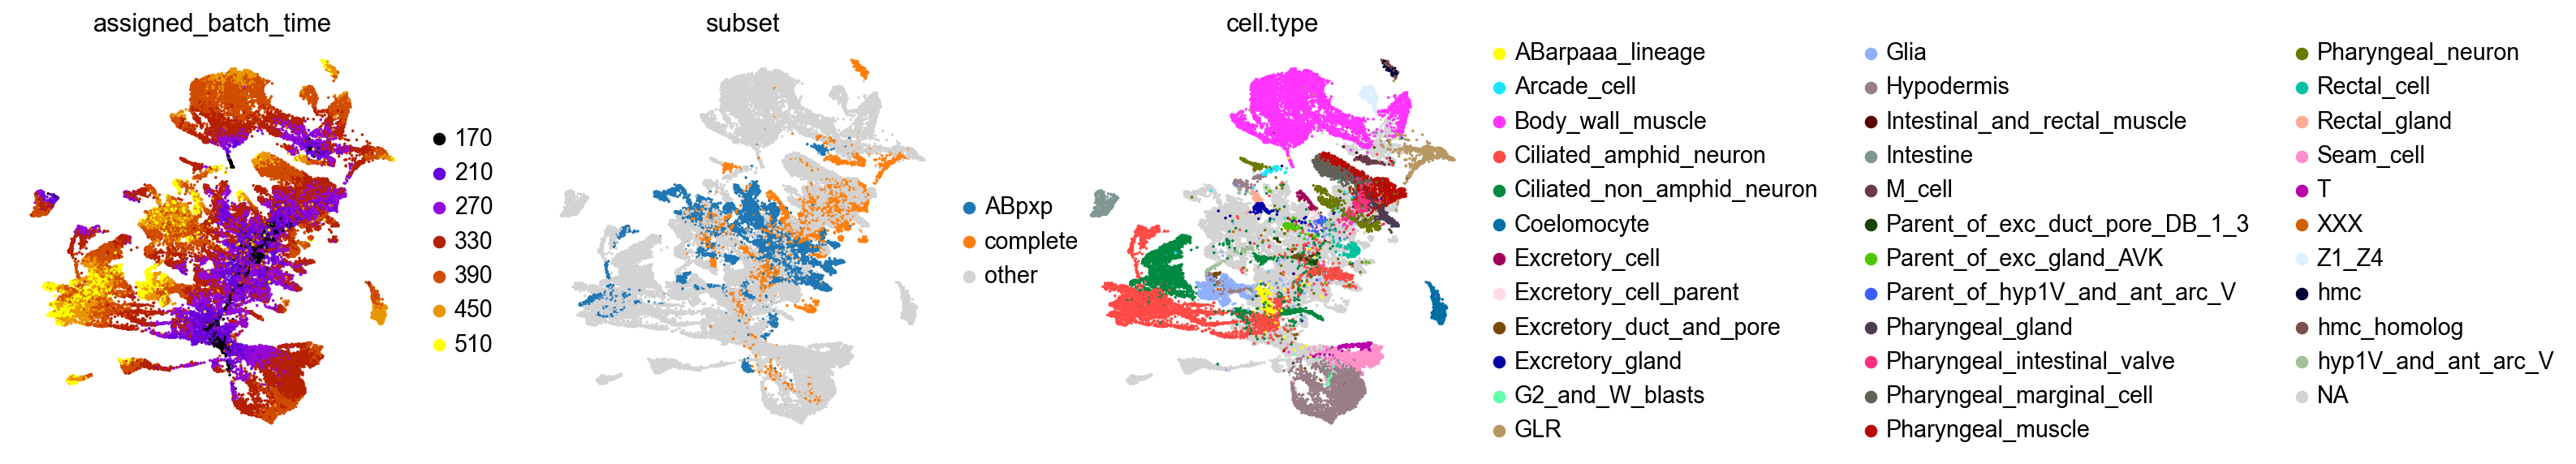

In [10]:
sc.pl.embedding(adata, basis="umap", color=[TIME_KEY, "subset", "cell.type"], size=10)

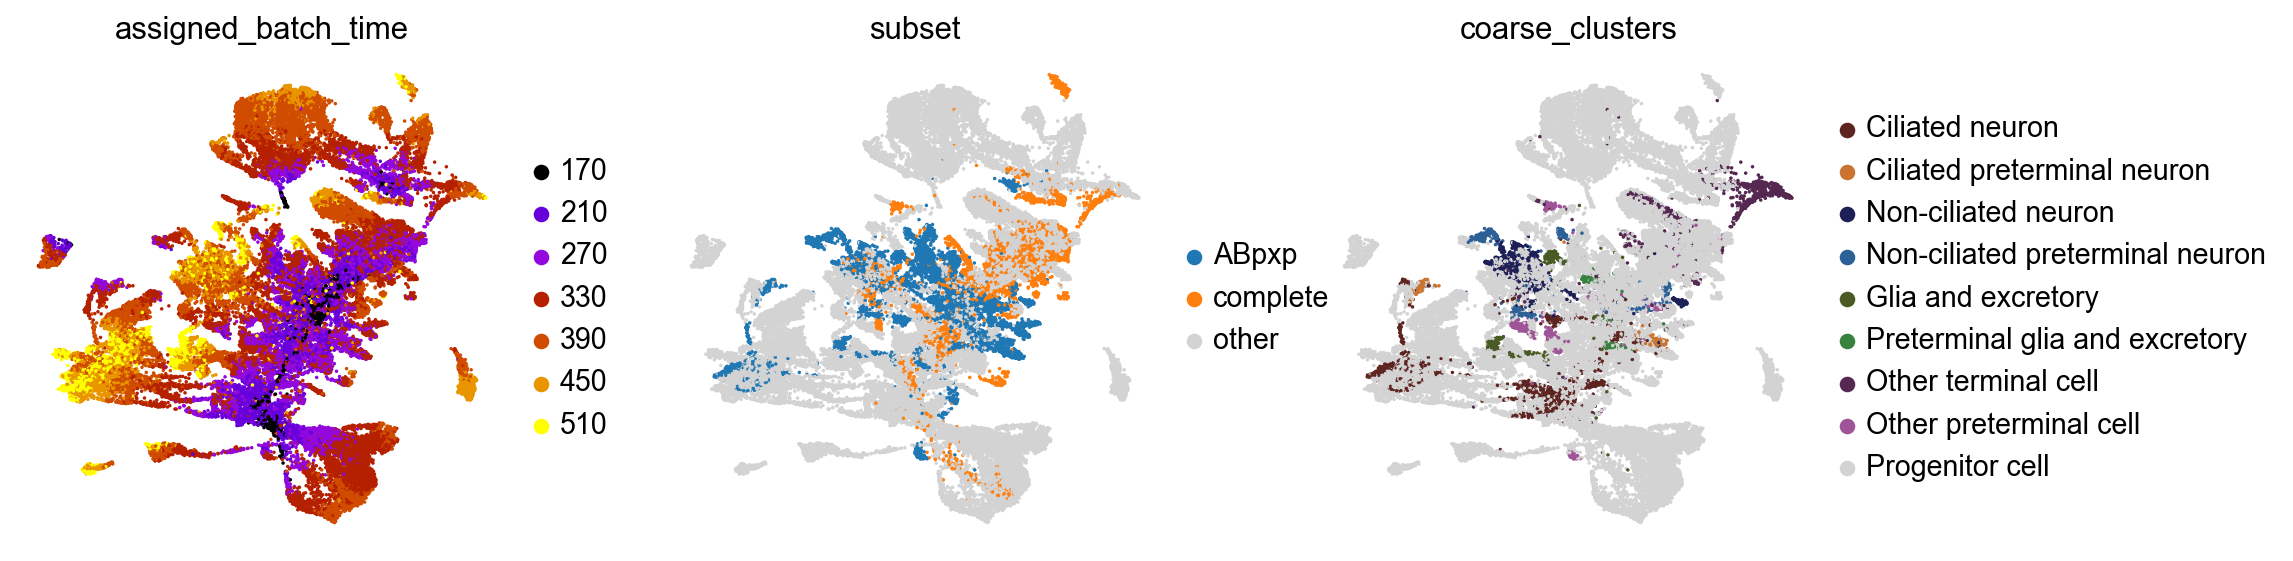

In [11]:
sc.pl.embedding(adata, basis="umap", color=[TIME_KEY, "subset", "coarse_clusters"], size=10)

### Visualize cell numbers

Let's first look at the number of cells per time point

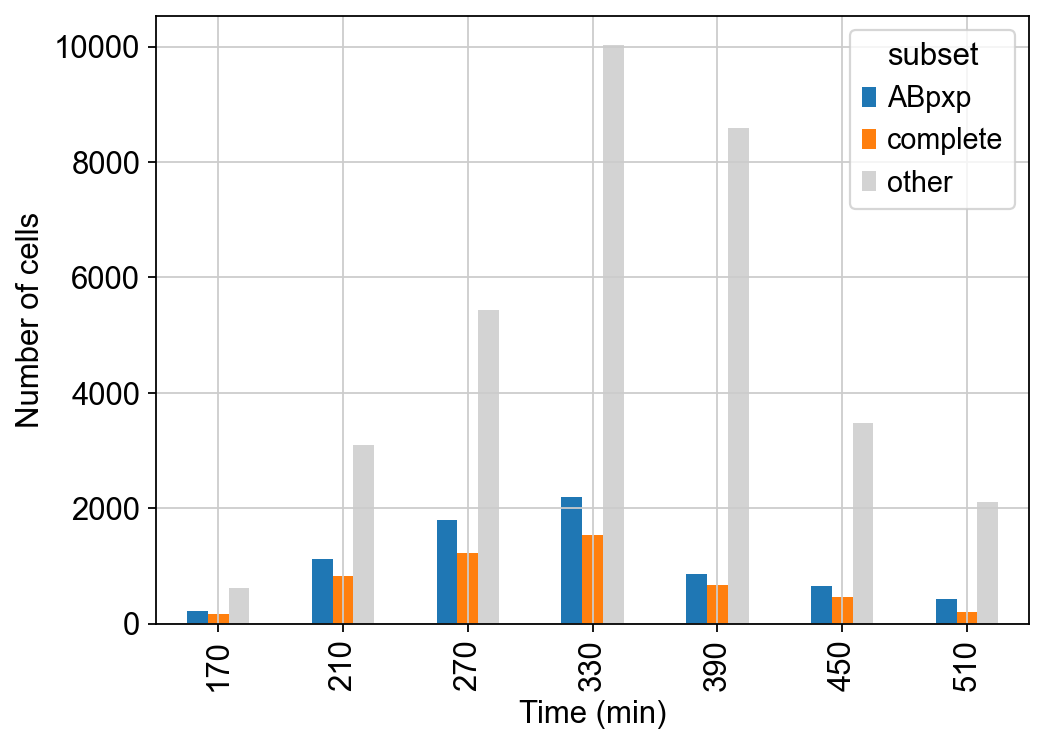

In [12]:
df = (
    adata.obs.groupby(
        [
            TIME_KEY,
            "subset",
        ]
    )
    .size()
    .unstack()
)
ax = df.plot(kind="bar", stacked=False, color=adata.uns["subset_colors"], figsize=(7, 5))
ax.set_xlabel("Time (min)")
ax.set_ylabel("Number of cells")

plt.show()

Let's also look at the difference in cell number between two adjacent time points. 

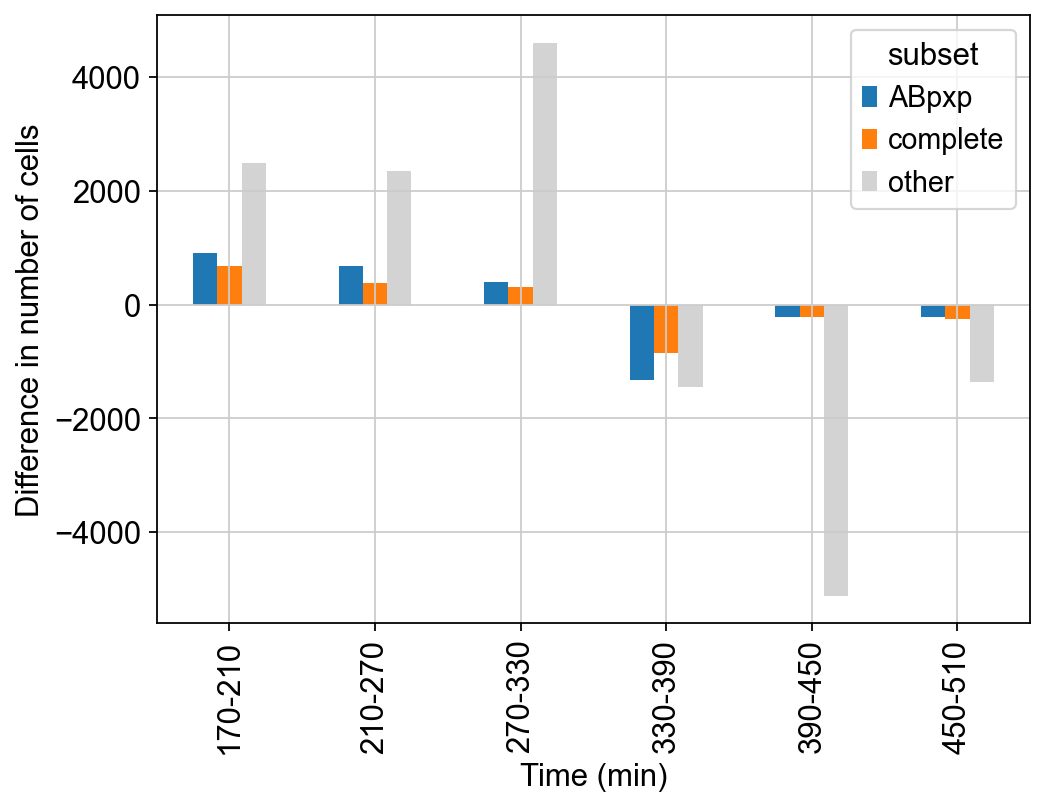

In [13]:
df = (
    adata.obs.groupby(
        [
            TIME_KEY,
            "subset",
        ]
    )
    .size()
    .unstack()
)
df = df.diff()

# Create new labels
new_labels = [f"{df.index[i-1]}-{df.index[i]}" for i in range(1, len(df.index))]
df = df.dropna()

ax = df.plot(kind="bar", stacked=False, color=adata.uns["subset_colors"], figsize=(7, 5))
ax.set_xticklabels(new_labels)

ax.set_xlabel("Time (min)")
ax.set_ylabel("Difference in number of cells")

plt.show()

### Visualize subsets over time

Let's subset to one kind of lineage information to observe how these cells distribute over the UMAP as a function of time. 

In [14]:
subsets = adata.obs["subset"].cat.categories
tps = adata.obs[TIME_KEY].cat.categories

for set in subsets:
    adata.obs[f"{TIME_KEY}_{set}"] = adata.obs[TIME_KEY].cat.rename_categories({tp: str(tp) for tp in tps})
    mask = adata.obs["subset"] != set
    adata.obs.loc[mask, f"{TIME_KEY}_{set}"] = None

    # assign consecutive colors to the new time annotations, which are restricted to the ABpxp lineage
    adata.uns[f"{TIME_KEY}_{set}_colors"] = [
        mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(tps)))
    ]

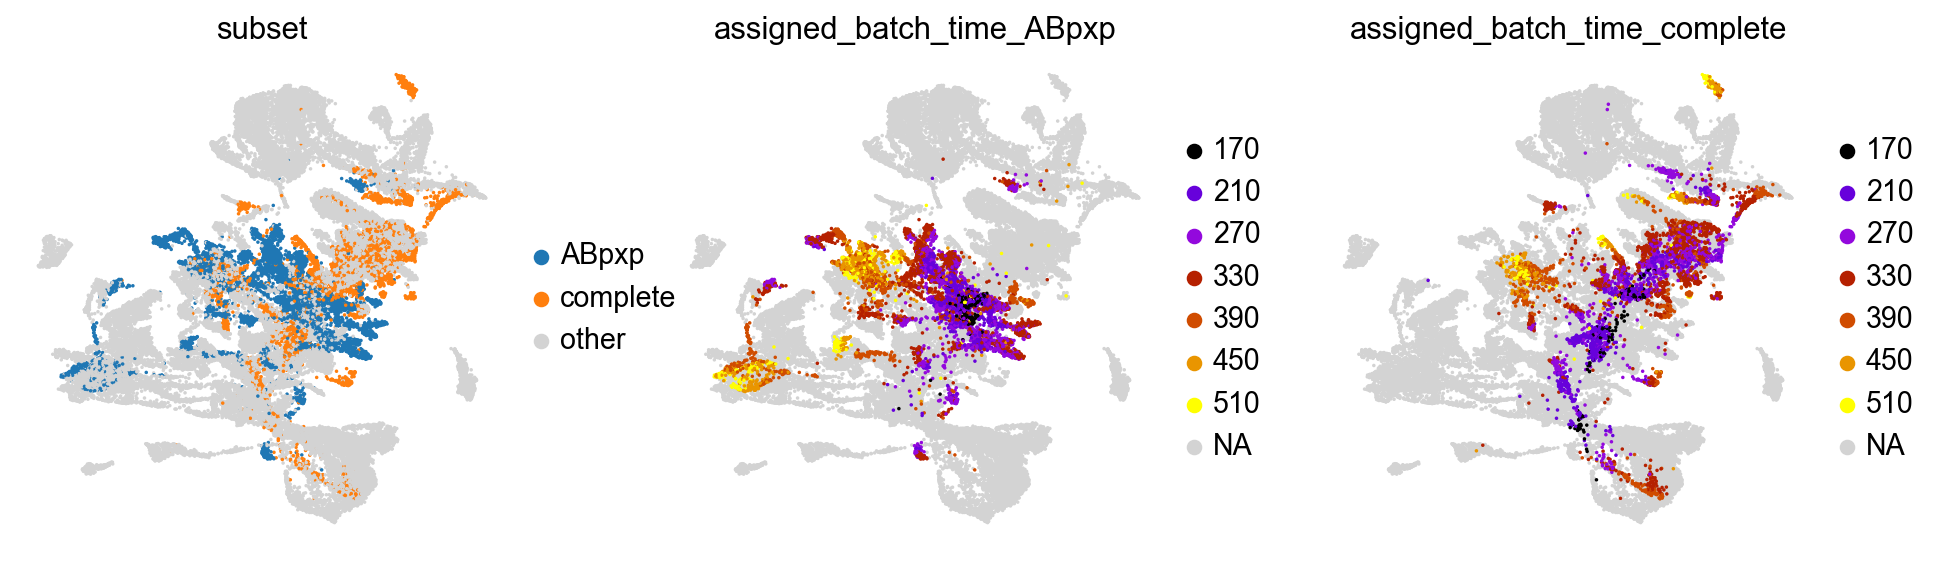

In [15]:
sc.pl.embedding(adata, basis="umap", color=["subset", f"{TIME_KEY}_ABpxp", f"{TIME_KEY}_complete"], size=10)